## Predict loan default 
The object of this notebook is to apply several classification methods to predict loan default. For each classification models, tune the hyper-parameters using grid search via cross validation. Evaluate different classifiers with ROC AUC metric and select the optimal model accordingly.

In [1]:
#!pip install mysql-connector
#import mysql.connector as sql_conn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import datetime as dt
from time import time

from __future__ import print_function
import os
import subprocess
from operator import itemgetter
from scipy.stats import randint

## 1. Data Cleaning

### load data from csv file

In [2]:
nan_values = ['nan','N.A','NaN','n/a']
data = pd.read_csv('loan.csv',na_values=nan_values, index_col='id')  

pd.set_option('display.max_columns', 101)
data.describe()

C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,433067.000000,137053.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,221703.000000,887379.0,511.000000,509.000000,887350.000000,8.171030e+05,8.171030e+05,21372.000000,21372.000000,21372.000000,21372.000000,20810.000000,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,34.063798,70.117903,11.548469,0.195307,1.692079e+04,55.067693,25.268026,8403.124852,8399.713242,7558.826684,7521.160306,5757.706424,1754.804327,0.396692,45.919243,4.880757,2164.145585,0.014380,44.104838,1.0,109981.011585,18.310118,0.004991,2.257026e+02,1.394582e+05,1.109021,2.928832,0.761651,1.674574,20.912686,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,21.884940,28.127914,5.317313,0.582091,2.242679e+04,23.834344,11.840561,8493.450269,8489.997617,7871.243336,7846.108604,6625.441046,2095.356099,4.087825,409.693874,63.125281,4794.783233,0.134191,22.179841,0.0,52730.379847,7.169233,0.077625,1.031137e+04,1.537500e+05,1.242675,3.089987,0.996035,1.688725,27.209081,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,17950.000000,3.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,NaN,11.910000,NaN,NaN,NaN,NaN,NaN,NaN,6.443000e+03,NaN,NaN,0.000000,0.000000,1914.590000,1899.700000,1200.570000,441.460000,0.000000,0.000000,0.000000,280.170000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,NaN,17.650000,NaN,NaN,NaN,NaN,NaN,NaN,1.187500e+04,NaN,NaN,6458.290000,6455.810000,4894.999117,4862.010000,3215.320000,1073.280000,0.000000,0.000000,0.000000,462.780000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,NaN,23.950000,NaN,NaN,NaN,NaN,NaN,NaN,2.082900e+04,NaN,NaN,13659.055000,13654.050000,10616.814231,10565.690000,8000.000000,2238.265000,0.000000,0.000000,0.000000,831.245000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.00000

### declare functions used in data cleaning

In [3]:
# extract numerical parts form textual feature
def year_to_int(string):
    try:
        if string == '10+ years':
            num=10
        elif string == '< 1 year':
            num=0
        else:
            num=int(str(string).split()[0])
        return num
    except:
        return np.nan

    
def percent_to_float(string):
    try:
        return float(string.split('%')[0])/100
    except:
        return np.nan

    
def str_to_timestamp(string):
    try:
        return dt.datetime.strptime(string, '%b-%Y').timestamp()
    except:
        return np.nan

In [4]:
def clean_data(data):
#response:
    # 1<--default, 0<--not default
    data['charge_off']=np.where((data['loan_status']=='Charged Off') | 
                                (data['loan_status']=='Default') |
                                (data['loan_status']=='Does not meet the credit policy. Status:Charged Off'), 1, 0) 

#predictor:
    data['revol_util'] = data['revol_util'].apply(percent_to_float)
    data['int_rate'] = data['int_rate'].apply(percent_to_float)
    data['earliest_cr_line'] = data['earliest_cr_line'].apply(str_to_timestamp)
    data['issue_d'] = data['issue_d'].apply(str_to_timestamp)
    data['emp_length'] = data['emp_length'].apply(year_to_int)
    
    #extended_inc: annual income varible that takes co-borrowers into consideration
    data['extended_inc']=np.where(data['application_type']=='JOINT',data['annual_inc_joint'],data['annual_inc'])
    
    return None

In [5]:
clean_data(data)

#remove intuitively useless or duplicated features
useless_col=['member_id','grade','annual_inc','funded_amnt_inv','collection_recovery_fee', 'pymnt_plan', 'recoveries', 'last_pymnt_d',
             'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'loan_amnt',
             'url', 'zip_code', 'acc_now_delinq', 'policy_code', 'loan_status','out_prncp','out_prncp_inv','funded_amnt',
            'emp_title', 'desc', 'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d', 'title' ]
data.drop(useless_col, axis=1, inplace=True)

#drop columns that contain more than 10% missing value
my_thresh = 0.9*len(data)
data.dropna(axis=1, thresh=my_thresh, inplace=True)

#remove any row with missing values in any field
data.dropna(axis=0, inplace=True)

data.head(3)

,term,installment,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,charge_off,extended_inc
id,,,,,,,,,,,,,,,,,,,,,,,,,
10149342,36 months,885.46,B2,10.0,OWN,Verified,1.385874e+09,debt_consolidation,MI,22.87,0.0,5.285232e+08,0.0,14.0,0.0,36638.0,27.0,w,0.0,INDIVIDUAL,0.0,114834.0,59900.0,0,55000.0
10159584,36 months,333.14,C1,1.0,RENT,Not Verified,1.385874e+09,debt_consolidation,CA,25.12,0.0,1.167628e+09,0.0,12.0,0.0,7967.0,28.0,f,0.0,INDIVIDUAL,0.0,14123.0,15100.0,0,26000.0
10159498,36 months,368.45,A2,10.0,MORTGAGE,Not Verified,1.385874e+09,debt_consolidation,CT,14.05,0.0,7.624980e+08,1.0,12.0,0.0,13168.0,22.0,w,0.0,INDIVIDUAL,0.0,267646.0,61100.0,0,105000.0


### categorical feature encoding

In [6]:
#ordinal
ordered_grade = ['G','F','E','D','C','B','A']
ordered_sub_grade = [x+i  for x in ordered_grade for i in ['5','4','3','2','1']]     
data.sub_grade = data.sub_grade.astype("category", ordered=True, categories=ordered_sub_grade).cat.codes

#nominal
nominal_col = ['term','initial_list_status','application_type','purpose','addr_state',
               'home_ownership','verification_status']
data = pd.get_dummies(data, columns=nominal_col)

data.describe()

,installment,sub_grade,emp_length,issue_d,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,charge_off,extended_inc,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
count,772608.000000,772608.000000,772608.000000,7.726080e+05,772608.000000,772608.000000,7.726080e+05,772608.000000,772608.000000,772608.000000,7.726080e+05,772608.000000,772608.000000,7.726080e+05,7.726080e+05,7.726080e+05,772608.000000,7.726080e+05,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000,772608.000000
mean,447.709943,22.969199,6.078650,1.413385e+09,18.386026,0.331529,9.019678e+08,0.671621,11.773878,0.201150,1.729570e+04,25.579978,0.015602,2.216288e+02,1.419347e+05,3.220577e+04,0.044249,7.693803e+04,0.687742,0.312258,0.472239,0.527761,0.999418,0.000582,0.008176,0.238429,0.601367,0.000001,0.056498,0.003725,0.017273,0.008900,0.005518,0.044150,0.000529,0.009349,0.004969,0.001116,0.002541,0.012526,0.007334,0.022705,0.144342,0.021585,0.015162,0.002648,0.002784,0.066995,0.032640,0.005263,0.000003,0.000003,0.040235,0.016858,0.009047,0.009621,0.011976,0.023074,0.023823,0.000610,0.025564,0.018491,0.015942,0.004570,0.002890,0.027953,0.000602,0.001443,0.004955,0.037297,0.005494,0.013747,0.082172,0.033487,0.009196,0.012125,0.035387,0.004419,0.011833,0.002093,0.015593,0.081757,0.007226,0.029609,0.002051,0.021957,0.013181,0.004864,0.002327,0.000004,0.506641,0.000053,0.000054,0.095255,0.397992,0.301734,0.392331,0.305935
std,244.721403,6.463778,3.665538,2.736918e+07,8.300998,0.887858,2.226572e+08,0.959244,5.368198,0.594596,2.283974e+04,11.858047,0.139828,1.059065e+04,1.549558e+

### split the data into training, validation and testing sets 

In [7]:
#split our data set into the three parts
# 60% - train set, used for classifier construction
# 20% - validation set, used for model selection 
# 20% - test set
train, validation, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [8]:
#split X and y
X_train = train.ix[:,data.columns!='charge_off']
y_train = train['charge_off'].reshape(-1,1).ravel()
X_validation = validation.ix[:,data.columns!='charge_off']
y_validation = validation['charge_off'].reshape(-1,1).ravel()
X_test = test.ix[:,data.columns!='charge_off']
y_test = test['charge_off'].reshape(-1,1).ravel

### feature scaling

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
#scaling
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype(np.float64)), columns=X_train.columns)
X_validation = pd.DataFrame(scaler.fit_transform(X_validation.astype(np.float64)), columns=X_validation.columns)
X_test = scaler.transform(X_test.astype(np.float64))

## 2. Grid Parameter Search via cross validation
parameter tuning is an important step in the model-building. We first define some functions that will be useful in parameter tuning. <br>
reference: http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html <br>

<b>report</b> - This function takes the output from the grid or random search, prints a report of the top models and returns the best parameter setting.

In [11]:
def report(grid_scores, n_top=3):
    """
    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report of top models, default n_top=3

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),    # itemgetter(n): fetches n-th element 
                        reverse=True)[:n_top]
    
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

<b>run_gridsearch</b> - This function runs a grid search for best tuning parameters

In [12]:
def run_gridsearch(X, y, clf, param_grid, scoring, cv=5):
    """
    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    scoring -- [string] defining model evaluation rules
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               scoring=scoring,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 3)
    return  top_params

### Performance Measures
Before applying the grid search to parameter tuning, we also need a evaluation metric to measure the performance of our classifiers. Selecting an appropriate evaluation metric is also important for model comparison.<br><br>
<b>Accuracy</b> is the most common evaluation metric for classification. However, it can be misleading if there is class imbalance in a dataset (i.e., one class is much more common than another). The loan data is highly unbalanced, since defaulted loans account for only a very small proportion of total loans. In this case, guessing the more common class (say, non-default) will often yield very high accuracy. Therefore, we should choose a different metric that is less sensitive to imbalance when evaluating the predictive performance of classifiers.<br><br>
It is obvious that the loss of accepting defaulted loans is much more serious, and thus we should adapt our classifiers to emphasize false negative rate (1-sensitivity) over false positive rate (specificity). However, it is difficult to assign a proper weight due to the lack of information on cost context. Considering this, we decide to use <b>AUC</b> to combine both sensitivity and specificity into a single general-purpose score. <br><br>
roc_auc_score: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

## 3. Constructing Classifiers

### 3.1. Linear Discriminant Analysis
Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) are two classic classifiers. These classifiers are attractive because they have closed-form solutions that can be easily computed and have no hyperparameters to tune. <br>

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fit the LDA model
lda = LinearDiscriminantAnalysis()
X_r = lda.fit(X_train, y_train).transform(X_train)

# make prediction using validation set
y_pred=dict()
y_pred_prob=dict()
y_pred['lda'] = lda.predict(X_validation)

# predicted probability for charge_off=1 i.e. default probability
y_pred_prob['lda'] = lda.predict_proba(X_validation)[:, 1]

C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<b>Dimensionality reduction using LDA</b>

LDA can be used to perform supervised dimensionality reduction, by projecting the input data to a linear subspace consisting of the directions which maximize the separation between classes. 
The dimension of the output is necessarily less than the number of classes, so this is a in general a rather strong dimensionality reduction. <br>
In this binary classfication case, we project the high dimensional data points onto a line (1-D) <br>
reference: http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

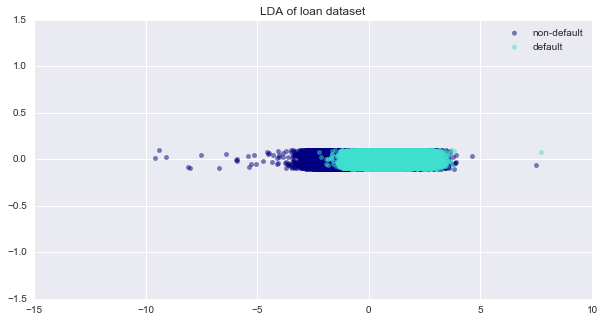

In [14]:
plt.figure(figsize=(10,5))

for color, i, y_label in zip(['navy', 'turquoise'], [0, 1], ['non-default', 'default']):
    plt.scatter(X_r[y_train == i], np.random.uniform(-0.1,0.1,sum(y_train == i)), alpha=.5, color=color, label = y_label)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.ylim(-1.5,1.5)
plt.title('LDA of loan dataset')

plt.show()

### 3.2. Quadratic Discriminant Analysis

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# fit the QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# make prediction using validation set
y_pred['qda'] = qda.predict(X_validation)

# predicted probability for charge_off=1 i.e. default probability
y_pred_prob['qda'] = qda.predict_proba(X_validation)[:, 1]

C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 3.3. L2 Regularized Logistic Regression Model
1.1.11. Logistic regression: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [16]:
from sklearn.linear_model import LogisticRegressionCV

# fit the logistic model
logit_r2 = LogisticRegressionCV(solver='sag', max_iter=3000)   # 'sag' is faster for large datasets
logit_r2.fit(X_train,y_train)

# make prediction using validation set
y_pred['logit_r2'] = logit_r2.predict(X_validation)

# predicted probability for charge_off=1 i.e. default probability
y_pred_prob['logit_r2'] = logit_r2.predict_proba(X_validation)[:, 1]

<b>Importance of features

C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


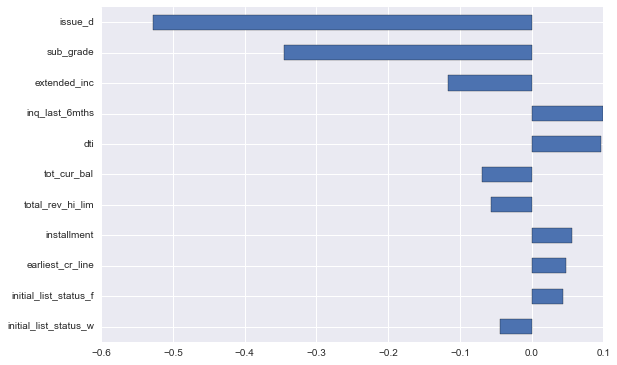

In [17]:
#top 10 features that contribute most
coefs = pd.Series(logit_r2.coef_[0], index=X_train.columns)
ordered_coefs = coefs.reindex(coefs.abs().order(ascending = False).index)
ordered_coefs[:11][::-1].plot(kind="barh", figsize=(9,6))

### 3.4. Decision Tree

In [18]:
#!pip install graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

<b>Application of grid search

In [19]:
scoring = ['accuracy', 'average_precision', 'f1', 'f1_weighted', 'roc_auc']

# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 5, 10],
              "max_leaf_nodes": [None, 5, 10] }

dt = DecisionTreeClassifier()
ts_gs = run_gridsearch(X_train, y_train, dt, param_grid, scoring[4], cv=10)


GridSearchCV took 1192.89 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.409 (std: 0.366)
Parameters: {'max_leaf_nodes': 5, 'criterion': 'entropy', 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.409 (std: 0.366)
Parameters: {'max_leaf_nodes': 5, 'criterion': 'entropy', 'min_samples_split': 5}

Model with rank: 3
Mean validation score: 0.409 (std: 0.366)
Parameters: {'max_leaf_nodes': 5, 'criterion': 'entropy', 'min_samples_split': 10}



<b>Test the retuned best parameters

In [20]:
dt_ts_gs = DecisionTreeClassifier(**ts_gs)
scores = cross_val_score(dt_ts_gs, X_train, y_train, scoring=scoring[4], cv=10)
print("{} (mean: {:.3f}, std: {:.3f})".format(scoring[4],
                                                       scores.mean(),
                                                       scores.std()),
                                                       end="\n\n" )

roc_auc (mean: 0.409, std: 0.366)



<b>Visualize decision tree

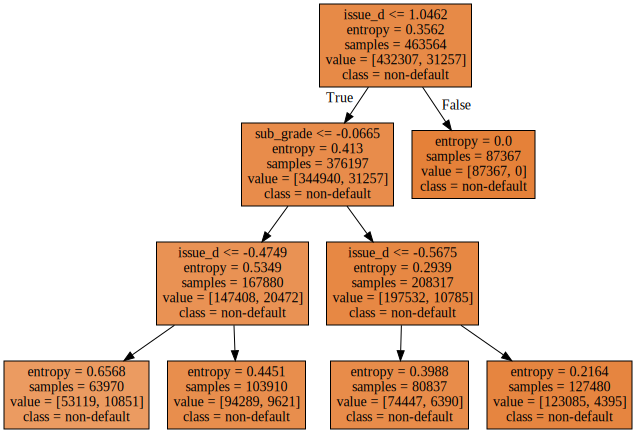

In [21]:
dt_ts_gs.fit(X_train,y_train)

dot_data = export_graphviz(dt_ts_gs, out_file=None,
                           feature_names=list(X_train.columns.values),
                           class_names=['non-default', 'default'],
                           filled=True)

Source(dot_data)

In [22]:
with open('best_tree.dot', 'w') as f:
    export_graphviz(dt_ts_gs, out_file=f,
                    feature_names=list(X_train.columns.values),
                    class_names=['default', 'not default'])

command = ["dot", "-Tpng", 'best_tree.dot', "-o", 'best_tree.png']
subprocess.check_call(command)

0

### 3.5. Random Forest
A random forest fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement

<b>Application of grid search

In [23]:
from sklearn.ensemble import RandomForestClassifier

# set of parameters to test
param_grid = {"n_estimators": list(range(1,10,2)),    #n_estimators : number of trees in the forest
              "max_features": [None, 5,'auto'],
              "criterion": ['entropy','gini'],
              "max_leaf_nodes":[5,10],
              "min_samples_split":[2,5]}

rf = RandomForestClassifier()
ts_gs = run_gridsearch(X_train, y_train, rf, param_grid, scoring[4], cv=10)


GridSearchCV took 5946.77 seconds for 120 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.607 (std: 0.067)
Parameters: {'max_features': 5, 'max_leaf_nodes': 10, 'n_estimators': 3, 'criterion': 'entropy', 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.585 (std: 0.086)
Parameters: {'max_features': 5, 'max_leaf_nodes': 10, 'n_estimators': 5, 'criterion': 'entropy', 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.569 (std: 0.057)
Parameters: {'max_features': 5, 'max_leaf_nodes': 10, 'n_estimators': 1, 'criterion': 'entropy', 'min_samples_split': 2}



<b>Test the retuned best parameters and fit the optimal model on training set

In [24]:
rf_ts_gs = RandomForestClassifier(**ts_gs) 

scores = cross_val_score(rf_ts_gs, X_train, y_train, scoring=scoring[4], cv=10)
print("{} (mean: {:.3f}, std: {:.3f})".format(scoring[4], scores.mean(), scores.std()), end="\n\n" )

roc_auc (mean: 0.495, std: 0.181)



<b>Fit the optimal model on training set and use it to predict validation data

In [25]:
rf_ts_gs.fit(X_train,y_train)
y_pred['random forest'] = rf_ts_gs.predict(X_validation)
y_pred_prob['random forest'] = rf_ts_gs.predict_proba(X_validation)[:, 1]

<b>Importance of features

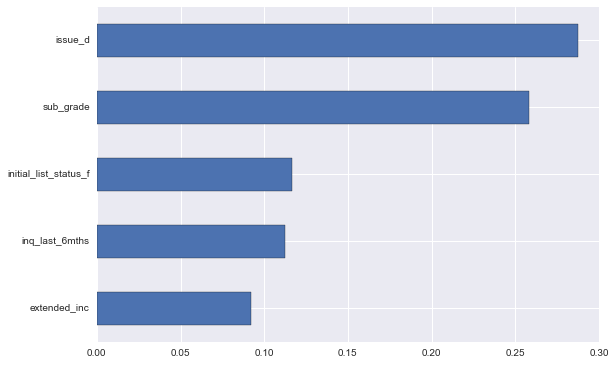

In [26]:
imp = pd.Series(rf_ts_gs.feature_importances_, index=X_train.columns)
imp.sort_values(ascending = False)[:5][::-1].plot(kind="barh", figsize=(9,6))

## 4. Performance Evaluation and Classifier Comparison

### 4.1. Histogram of Predicted Default Probabilities
When we call the predict() method, the algorithm simply convert the predicted probabilities into predictions by choosing the class with pred_proba > 0.5. 
However, predicted probability calculated in this way can be inaccurate because of class imbalance. <br>
To improve the sensitivity and get a better prediction, we can choose a more appropriate threshold instead of 0.5

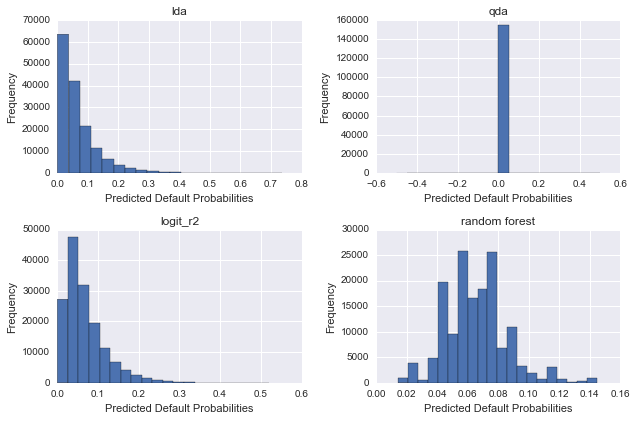

In [27]:
COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(9,6))

for i, (label, prob) in enumerate(y_pred_prob.items()): 
    ax = axes[int(i/COL_NUM), int(i%COL_NUM)]
    pd.DataFrame(prob).plot(kind='hist', bins=20, ax=ax)
    ax.set_title('{}'.format(label))
    ax.set_xlabel('Predicted Default Probabilities')
    ax.legend_.remove()
    
plt.tight_layout() 

### 4.2. ROC Curve
<b>ROC for threshold selection</b><br>
ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings. 
The specification of optimal thresholds depends on the problem we want to solve. <br>
<b>ROC for model selection</b><br>
For a perfect classifier the ROC curve will go straight up the Y axis (true positive) and then along the X axis (false positive). A classifier with no power will sit on the diagonal, while most classifiers fall somewhere in between.<br>
if two ROC do not intersect, one method dominantes the other<br>
if two ROC intersect, one method is better for some thresholds, and other method is better for other thresholds.

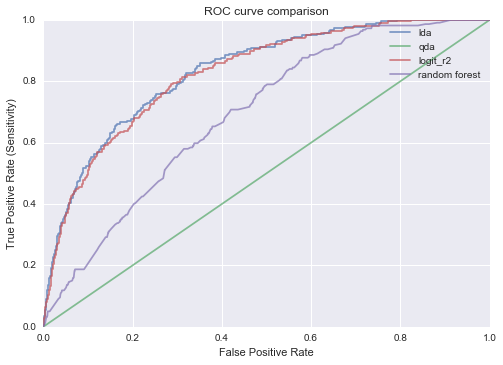

In [28]:
#ROC Curve
fpr=dict()
tpr=dict()
thresholds=dict()

for label, prob in y_pred_prob.items(): 
    fpr[label], tpr[label], thresholds[label] = metrics.roc_curve(y_validation, prob)
    plt.plot(fpr[label], tpr[label], label=label, alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve comparison') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

### 4.3. AUC
AUC is measured by the area under the ROC curve. It give us a convenient way of measuring model performances and comparing models. <br>
AUC for a classifier with no power is 0.5. AUC for the perfect classifier is 1.0. Most classifiers have AUCs that fall somewhere between these 0.5 and 1
Reducing the ROC Curve to a single number can be misleading when two ROC curve intersect. Therefore, we consider AUC to be a  complementary metric for model selection

In [29]:
auc=dict()
for label, prob in y_pred_prob.items(): 
    auc[label] = metrics.roc_auc_score(y_validation, prob)
    print(label,":", auc[label])

lda : 0.83277618072
qda : 0.5
logit_r2 : 0.826040515611
random forest : 0.694075231272


<b>It seems that LDA works best

## 5. Re-fit the optimal model on training+validation set

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fit the LDA model
lda = LinearDiscriminantAnalysis()

new_train = pd.concat([train, validation])
X_new_train = new_train.ix[:,data.columns!=['charge_off']]
y_new_train = new_train['charge_off'].reshape(-1,1).ravel()

# fit the optimal model to both traing and validation set
lda.fit(X_new_train, y_new_train)

# predict the test data (predicted probability)
y_pred_prob_opt = lda.predict_proba(X_test)[:, 1]

C:\Program Files_cy\Python_3.5\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<b>evaluate_threshold</b> - This function shows how sensitivity and specificity change with varing threshold by summarizing them in a table. 

In [31]:
def evaluate_threshold(fpr, tpr, thresholds, thres_min=0, thres_max=1, step=0.1):
    thres_list = np.arange(thres_min, thres_max, step)
    sens=[]
    spec=[]
    
    for x in thres_list:
        sens.append(tpr[thresholds>x][-1])
        spec.append(1-fpr[thresholds>x][-1])
        
    df = pd.DataFrame(thres_list, columns=['threshold'])
    df['sensitivity']=sens
    df['specificity']=spec
    return df

In [32]:
fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(y_new_train, lda.predict_proba(X_new_train)[:, 1])
evaluate_threshold(fpr_opt, tpr_opt, thresholds_opt, thres_min=0, thres_max=0.1, step=0.01)

,threshold,sensitivity,specificity
0,0.00,1.000000,0.000000
1,0.01,0.997808,0.248407
2,0.02,0.975886,0.436186
3,0.03,0.925594,0.552197
4,0.04,0.856653,0.637487
5,0.05,0.784884,0.702567
6,0.06,0.712892,0.753374
7,0.07,0.644682,0.793280
8,0.08,0.582793,0.825032
9,0.09,0.523859,0.850918


Before choosing the best threshold, we would like to introduce the last classification method -- <b>Support Vector Machine (SVM)</b>. We didn't mention it above because it is different from the methods we have used so far, for it returns only 0 or 1 rather than probability estimates. Hence, there is no threshold to choose, and the definition of ROC Curve is different. <br><br>
But we still want to try this method because it possesses the following advantages:<br>
SVM with a non linear kernel can help us solve problems that are not linearly separable<br>
Effective in high dimensional spaces

## Support Vector Machine

We use a new evaluation metrics different from AUC <br>
Note that we didn't tune parameters in this case, because kernelized SVM would take a long time to learn the data.

In [ ]:
from sklearn.svm import SVC   # default kernel is 'rbf'

# set of parameters to test
#param_grid = {"C": [0.1, 1, 10],                 #C : Penalty parameter of the error term
#              "gamma": [0.1, 1, 10],                 #gamma: Kernel coefficient for ‘rbf’
#              "class_weight": [None, 'balanced', {1: 10}] } #balanced: adjust weights inversely proportional to class frequencies 

#ts_gs = run_gridsearch(X_new_train, y_new_train, svm, param_grid, scoring[2], cv=5)  #scoring[2]='weighted_f1'
# f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
# weighted_f1: weighted f1 by the number of true instances for each class. It accounts for label imbalance. 

In [ ]:
#svm = SVC(**ts_gs)
svm = SVC(kernel='linear', class_weight='balanced')

svm.fit(X_new_train,y_new_train)

y_pred['svm'] = svm.predict(X_test)

### Evaluate the performance by confusion matrix

<b>confusion</b> -- This function computes and visualizes the confusion matrix

In [ ]:
def confusion(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=['non-default', 'default'], yticklabels=['non-default','default'])
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")
    
    d={'True Negative':cm[0,0], 'False Positive':cm[0,1], 'False Negative':cm[1,0], 'True Positive':cm[1,1]}

    return(d)

True Negative -- actual non-default & predict non-default (correct)<br>
False Positive -- actual non-default & predict default (incorrect)<br>
False Negative -- actual default & predict non-default (incorrect)<br>
True Positive -- actual default & predict default (correct)

In [ ]:
# calculate sensitivity 
print ("The fraction of defaulters that are correctly identified:", metrics.recall_score(y_test, y_pred['svm']) )

# confusion matrix
confusion(y_test, y_pred['svm'])

## LDA Vs. SVM

In order to compare the svm mehtod with other methods we mentioned above, we choose a threshold for the previously optimal model that can achieve a sensitivity slightly higher than 
Notice that this threshold is selected based on the performance on new_training data, the performance on test set can be worse because the test error is usually higher than training error.

In [ ]:
# predict default on test set with a new threshold
from sklearn.preprocessing import binarize
y_pred['opt'] = binarize(y_pred_prob['opt'], 0.06)[0]

In [ ]:
# calculate sensitivity 
print ("The fraction of defaulters that are correctly identified:", metrics.recall_score(y_test, y_pred['opt']) )

# confusion matrix
confusion(y_test,  y_pred['opt'])